In [58]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import misc
import scipy

from matplotlib.pyplot import imread

# Generating Mask
### Method for Generating Mask

In [59]:
def Generte_Masks(sigma,T):
    '''
    A method for generating Gaussian Derivative Filters.
    Arguments
    
    sigma: Standard Deviation of Gaussian
    T:     (T>=0.5) Threshold the gaussian for selecting 
            a finite segment of gaussian
    
    '''
    assert sigma>=0.5
    #Calculating Size of Filter By threshholding the value of Gaussian at T
    half_size=np.round(np.sqrt(-np.log(T)*2*sigma**2))
    size=half_size*2+1
    
    
    
    normal = 1 / (2.0 * np.pi * sigma**2)
    # Creating X and Y axis
    x, y = np.mgrid[-half_size:half_size+1, -half_size:half_size+1]
    
    # Creating Filters
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal 
    Gx =  (-x/(sigma**2))*np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    Gy =  (-y/(sigma**2))*np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    # Scaling by 255
    Gx=np.round(Gx*255)
    Gy=np.round(Gy*255)
    
    return Gx,Gy


def rgb2gray(rgb):
    '''
    A method for converting RGB to Gray scale
    '''
    
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [60]:
Gy,Gx=Generte_Masks(sigma=1.5,T=0.2)

In [61]:
Gx

array([[ 0.,  1.,  1., -0., -1., -1., -0.],
       [ 1.,  3.,  3., -0., -3., -3., -1.],
       [ 3.,  5.,  5., -0., -5., -5., -3.],
       [ 3.,  7.,  6., -0., -6., -7., -3.],
       [ 3.,  5.,  5., -0., -5., -5., -3.],
       [ 1.,  3.,  3., -0., -3., -3., -1.],
       [ 0.,  1.,  1., -0., -1., -1., -0.]])

In [62]:
Gy.shape

(7, 7)

### Reading Image in numpy array

In [63]:
Image=imread('circle.jpg')
Image=rgb2gray(Image)


In [64]:
Image.shape

(650, 650)

### Method 2d Convolution  

In [65]:
def convolution(image, filter_):
    '''
    An Implementation of 2D convolution by zero padding 
    and keeping the size of input and output same.
    '''
    m, n = filter_.shape
    r ,c = image.shape
    # Making New Image by Padding Zeros
    new_image=np.zeros((r+m-1,c+n-1))
    new_image[m//2:r+m//2,n//2:c+n//2]=image
    output=np.zeros((r,c))
    # Performing convolution on zero padded image
    for i in range(r):
        for j in range(c):
            output[i][j] = np.sum(new_image[i:i+m, j:j+n]*filter_)
    
    return output

### Appllying Gaussian Applying Masks to Images
#### To Get Gradients "fx" And "fy"

In [66]:
fx= convolution(Image,Gx)
fy= convolution(Image,Gy)

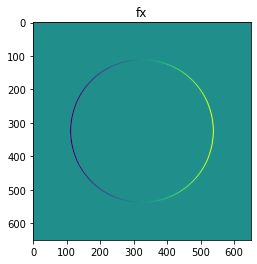

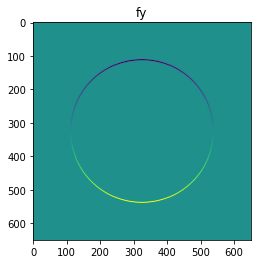

In [67]:
plt.figure()
plt.imshow(fx)
plt.title('fx')
plt.show()

plt.figure()
plt.title('fy')
plt.imshow(fy)
plt.show()

## Magnitude of Derivative

60.52158975897382


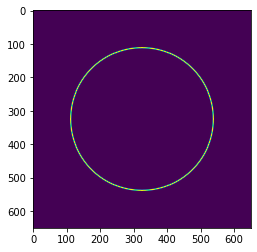

In [68]:
Mag=np.sqrt(fx**2+fy**2)/255
plt.imshow(Mag)
print(np.max(Mag))

### Finding Angle Theta And Converting In Range 0-360

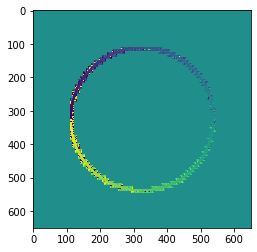

In [69]:
Theta=np.zeros(Image.shape)
Theta=np.arctan2(fy,fx)
Theta[(fx<1e-4)& (abs(fy)<1e-4)]=0
Theta=Theta*(180/np.pi)+180
plt.figure()
plt.imshow(Theta)
plt.show()

### Rounding Off Theta In Four Directions
#### A Method for rounding theta in four directions

In [70]:
def Round_Theta(Theta):
    '''
    A method for rounding theta in four directions only
    '''
    
    Theta_I=np.zeros(Theta.shape)
    Theta_I[((Theta>0) & (Theta<22.5)) | ((Theta>157.5) & (Theta<202.5)) | ((Theta>337.5) & (Theta<360))]=0
    Theta_I[((Theta>22.5) & (Theta<67.5)) | ((Theta>202.5) & (Theta<247.5)) ]=1
    Theta_I[((Theta>67.5) & (Theta<112.5)) | ((Theta>247.5) & (Theta<292.5)) ]=2
    Theta_I[((Theta>112.5) & (Theta<157.5)) | ((Theta>292.5) & (Theta<337.5)) ]=3
    
    return Theta_I

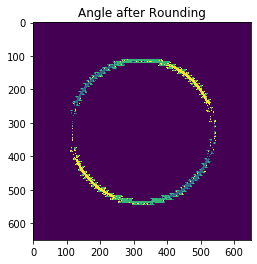

In [71]:
Theta_I=Round_Theta(Theta)
plt.figure()
plt.title('Angle after Rounding')
plt.imshow(Theta_I)
plt.show()

## Applying Non-Maximum Suppression

### A Method for applying Non-Maximum Suppression

In [72]:
def NMS(Mag,Theta):
    '''
    An implementation of Non-Maximum Suppression
    Arguments:
    Mag: Magnitude of gradients
    Theta: Angle of edges
    '''
    
    R,C=Mag.shape
    Mag_n=np.zeros(Mag.shape)
    Mag_n=Mag.copy()
    #Applying Non Maximum suppression by applying setting
    #to zero the pixels which has neighours greater than it.
    for r in range(R):
        for c in range(C):
            if (c>0 and r>0 and c<C-1 and r<R-1):
                if Theta[r,c]==0:
                    if not (Mag_n[r,c]>Mag_n[r,c+1] and Mag_n[r,c]>Mag_n[r,c-1]):
                        Mag_n[r,c]=0
                        
                elif Theta[r,c]==1:
                    if not (Mag_n[r,c]>Mag_n[r-1,c+1] and Mag_n[r,c]>Mag_n[r+1,c-1]):
                        Mag_n[r,c]=0
                    
                elif Theta[r,c]==2:
                    if not (Mag_n[r,c]>Mag_n[r-1,c] and Mag_n[r,c]>Mag_n[r+1,c]):
                        Mag_n[r,c]=0
                elif Theta[r,c]==3:
                    if not (Mag_n[r,c]>Mag_n[r+1,c+1] and Mag_n[r,c]>Mag_n[r-1,c-1]):
                        Mag_n[r,c]=0
    return Mag_n
    
    
    

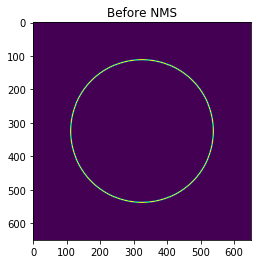

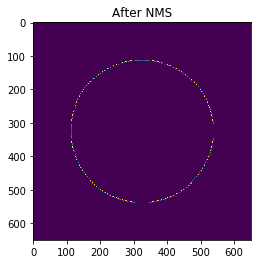

60.52158975897382


In [73]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before NMS")
plt.imshow(Mag)
plt.show()
plt.figure()
plt.title("After NMS")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))

## Applying Hysteresis Thresholding
### A method for Hysteresis Thresholding

In [74]:
def hysteresis(img, TI, TH):
    '''
    An Implementation of hysteresis By getting iterating over all pixels
    which have values equal or greater than TI and its aat leat one from 
    eight neighbours is greater than TH.
    It is recursive because I am updating same Image.
    ARGUMENTS:
    img: input Image
    TI:  lower threshold
    TH:  upper threshold
    
    '''
    M, N = img.shape 
    for i in range(1, M-1):
        for j in range(1, N-1):
            if ((img[i,j] >= TI) and (img[i,j] < TH)):
                try:
                    if ((img[i+1, j-1] >= TH) or (img[i+1, j] >= TH) or (img[i+1, j+1] >= TH)
                        or (img[i, j-1] >= TH) or (img[i, j+1] >= TH)
                        or (img[i-1, j-1] >= TH) or (img[i-1, j] >= TH) or (img[i-1, j+1] >= TH)):
                        
                        img[i, j] = max( img[i+1, j-1]  , img[i+1, j]   , img[i+1, j+1], img[i, j-1] ,
                                         img[i, j+1]    , img[i-1, j-1] ,img[i-1, j]  ,img[i-1, j+1] )
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [75]:
np.max(Mag_n)

60.52158975897382

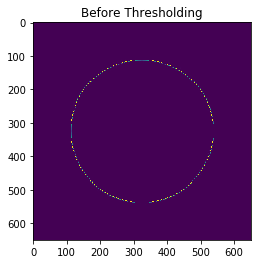

60.52158975897382


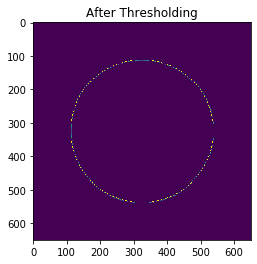

In [76]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before Thresholding")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))
Mag_nh=hysteresis(Mag_n,1,2)
plt.figure()
plt.title("After Thresholding")
plt.imshow(Mag_nh)
plt.show()

# $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  MECCA Image

In [77]:
Image=imread('mecca06.jpg')
Image=rgb2gray(Image)


In [78]:
fx= convolution(Image,Gx)
fy= convolution(Image,Gy)

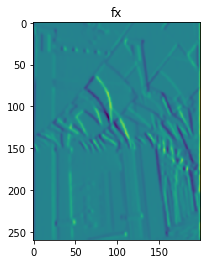

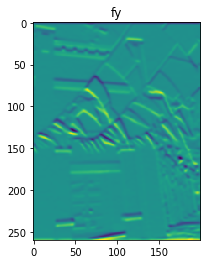

In [79]:
plt.figure()
plt.imshow(fx)
plt.title('fx')
plt.show()

plt.figure()
plt.title('fy')
plt.imshow(fy)
plt.show()

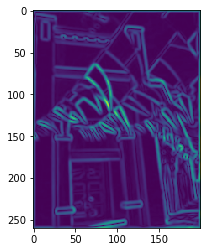

In [80]:
Mag=np.sqrt(fx**2+fy**2)/255
plt.imshow(Mag)

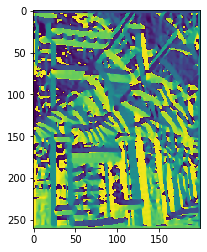

In [81]:
Theta=np.zeros(Image.shape)
Theta=np.arctan2(fy,fx)
Theta=Theta*(180/np.pi)+180
plt.figure()
plt.imshow(Theta)
plt.show()

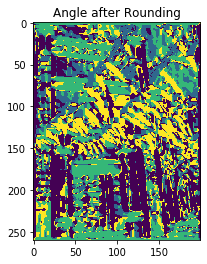

In [82]:
Theta_I=Round_Theta(Theta)
plt.figure()
plt.title('Angle after Rounding')
plt.imshow(Theta_I)
plt.show()

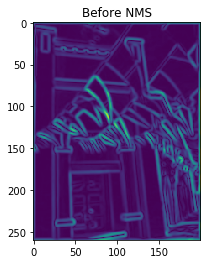

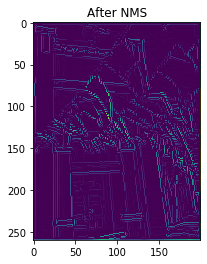

59.06861289513667


In [83]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before NMS")
plt.imshow(Mag)
plt.show()
plt.figure()
plt.title("After NMS")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))

In [84]:
np.max(Mag_n)

59.06861289513667

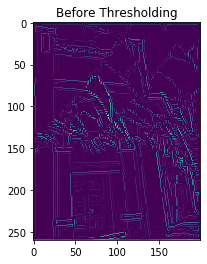

59.06861289513667


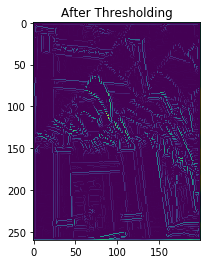

In [85]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before Thresholding")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))
Mag_nh=hysteresis(Mag_n,1,2)
plt.figure()
plt.title("After Thresholding")
plt.imshow(Mag_nh)
plt.show()

#  $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ CT SCAN Image

In [86]:
Image=imread('ctscan.tif')
Image=rgb2gray(Image)


In [87]:
fx= convolution(Image,Gx)
fy= convolution(Image,Gy)

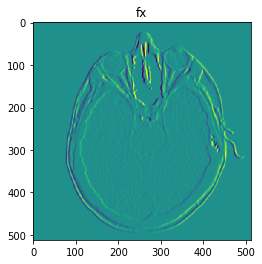

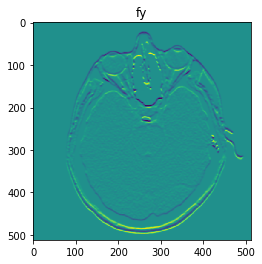

In [88]:
plt.figure()
plt.title("fx")
plt.imshow(fx)
plt.show()

plt.figure()
plt.title("fy")
plt.imshow(fy)
plt.show()

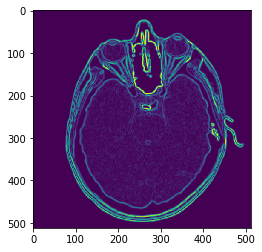

In [89]:
Mag=np.sqrt(fx**2+fy**2)/255
plt.imshow(Mag)

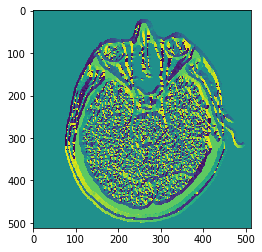

In [90]:
Theta=np.zeros(Image.shape)
Theta=np.arctan2(fy,fx)
Theta=Theta*(180/np.pi)+180
plt.figure()
plt.imshow(Theta)
plt.show()

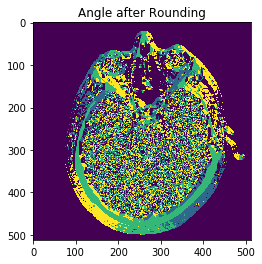

In [91]:
Theta_I=Round_Theta(Theta)
plt.figure()
plt.title('Angle after Rounding')
plt.imshow(Theta_I)
plt.show()

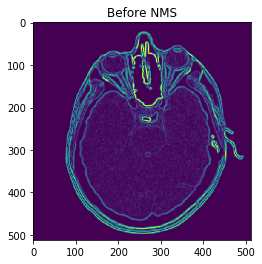

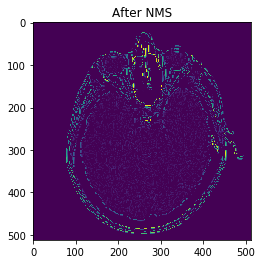

62.09048911516159


In [92]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before NMS")
plt.imshow(Mag)
plt.show()
plt.figure()
plt.title("After NMS")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))

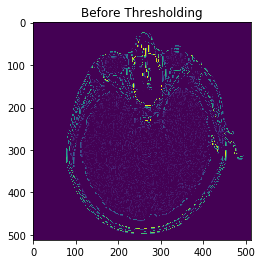

62.09048911516159


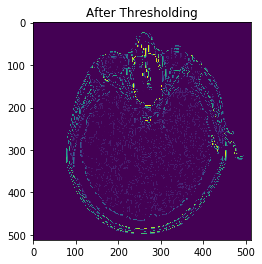

In [93]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before Thresholding")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))
Mag_nh=hysteresis(Mag_n,1,4)
plt.figure()
plt.title("After Thresholding")
plt.imshow(Mag_nh)
plt.show()

 # $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ X-RAY Image     

In [94]:
Image=imread('xray.tif')

In [95]:
fx= convolution(Image,Gx)
fy= convolution(Image,Gy)

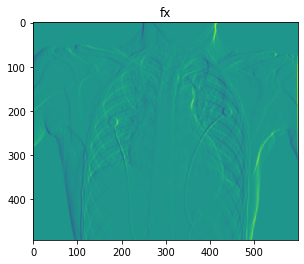

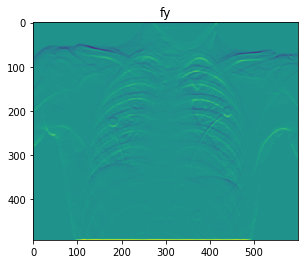

In [96]:
plt.figure()
plt.title("fx")
plt.imshow(fx)
plt.show()

plt.figure()
plt.title("fy")
plt.imshow(fy)
plt.show()

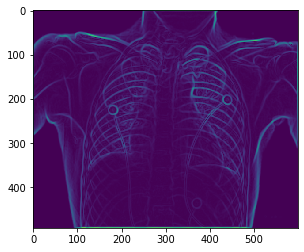

In [97]:
Mag=np.sqrt(fx**2+fy**2)/255
plt.imshow(Mag)

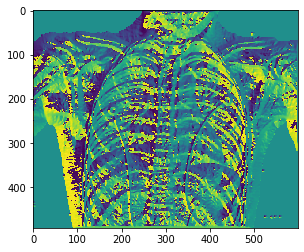

In [98]:
Theta=np.zeros(Image.shape)
Theta=np.arctan2(fy,fx)
Theta=Theta*(180/np.pi)+180
plt.figure()
plt.imshow(Theta)
plt.show()

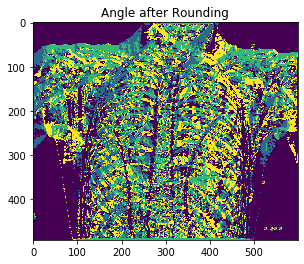

In [99]:
Theta_I=Round_Theta(Theta)
plt.figure()
plt.title('Angle after Rounding')
plt.imshow(Theta_I)
plt.show()

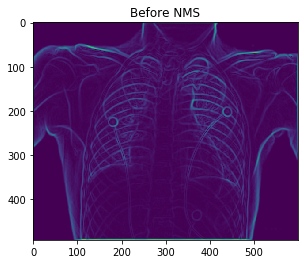

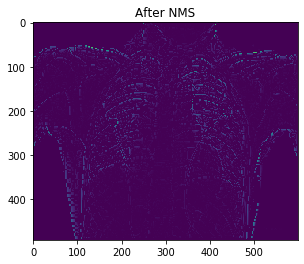

59.01179402382234


In [100]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before NMS")
plt.imshow(Mag)
plt.show()
plt.figure()
plt.title("After NMS")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))

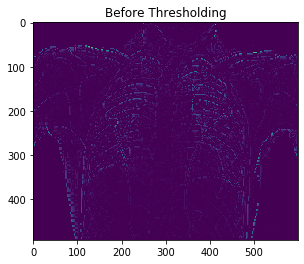

59.01179402382234


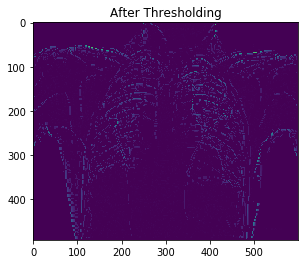

In [101]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before Thresholding")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))
Mag_nh=hysteresis(Mag_n,1,4)
plt.figure()
plt.title("After Thresholding")
plt.imshow(Mag_nh)
plt.show()

# $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  shapessm Image

In [102]:
Image=imread('shapessm.jpg')


In [103]:
fx= convolution(Image,Gx)
fy= convolution(Image,Gy)

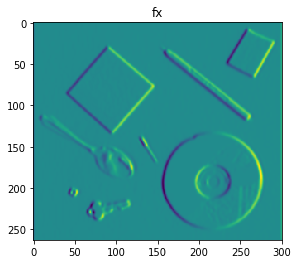

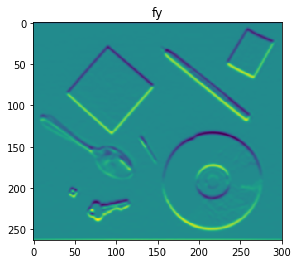

In [104]:
plt.figure()
plt.title("fx")
plt.imshow(fx)
plt.show()

plt.figure()
plt.title("fy")
plt.imshow(fy)
plt.show()

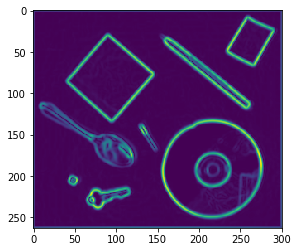

In [105]:
Mag=np.sqrt(fx**2+fy**2)/255
plt.imshow(Mag)

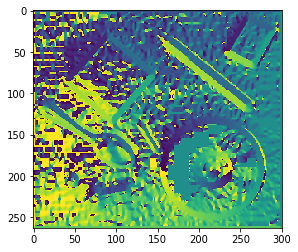

In [106]:
Theta=np.zeros(Image.shape)
Theta=np.arctan2(fy,fx)
Theta=Theta*(180/np.pi)+180
plt.figure()
plt.imshow(Theta)
plt.show()

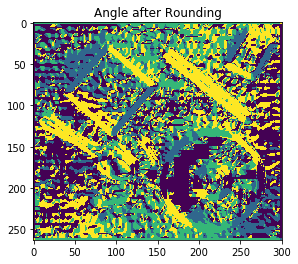

In [107]:
Theta_I=Round_Theta(Theta)
plt.figure()
plt.title('Angle after Rounding')
plt.imshow(Theta_I)
plt.show()

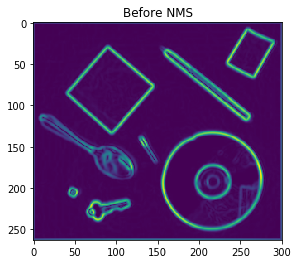

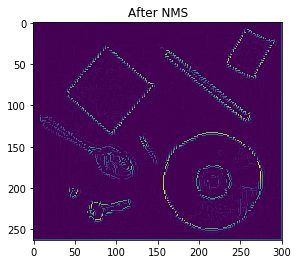

44.798382632693226


In [108]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before NMS")
plt.imshow(Mag)
plt.show()
plt.figure()
plt.title("After NMS")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))

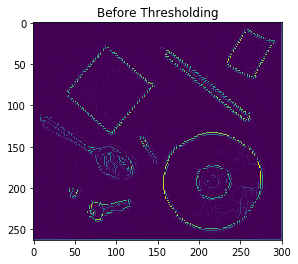

44.798382632693226


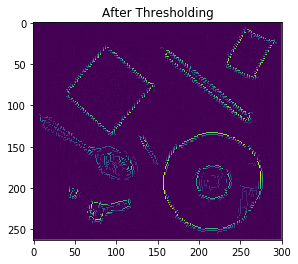

In [109]:
Mag_n=NMS(Mag,Theta_I)
plt.figure()
plt.title("Before Thresholding")
plt.imshow(Mag_n)
plt.show()
print(np.max(Mag_n))
Mag_nh=hysteresis(Mag_n,1,4)
plt.figure()
plt.title("After Thresholding")
plt.imshow(Mag_nh)
plt.show()